# Content

In this notebook we briefly show how to reproduce the results shown in the Figures 2,3,4,5 of our paper ```Nishimori meets Bethe:  a  spectral method for node classification in sparse weighted graphs```.

In all cases, the codes have paramaters slightly different from the ones shown in the paper: this choice is made so to allow the practitioner to run the codes in few seconds. The results of our article can be reproduced by setting the parameters indicated in the captions of the images but require a longer computational time.

In [1]:
# upload the source files

include("src/basic_functions.jl")
include("src/NBNC.jl")

using Plots, LaTeXStrings ## these packages are used just for the plots


gr(size=(140,100), xtickfontsize = 4, ytickfontsize = 4, linewidth = 0.5, legendfontsize = 2, markersize = 2)

;

## Figure 2

With this code we produce the result of Figure 2, showing the spectrum of the matrix $B$ against the theoretical prediction of Claim 1. The parameters are set so to obtain a sparse graph. By changing the value of $c$ the dense setting can be obtained. Note that the size of $B$ scales as $nc$ and the complexity to compute all the eigenvalues as $O((nc)^3)$, so these parameters must be tuned carefully. 

The following code runs in approximately $10$ seconds, because we considered a small value of $n$ (smaller than the one shown in Figure 2). As a consequence, the thoeretical prediction may slightly differ from the simulation, expecially for the leading eigenvalue. This is cured by simply increasing the value of $n$.

  8.907300 seconds (2.59 M allocations: 218.944 MiB, 1.13% gc time)


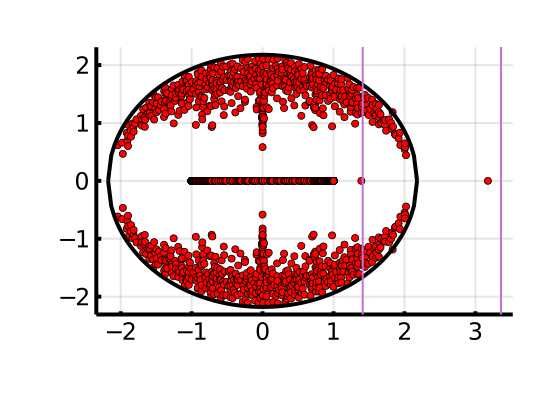

In [2]:
@time begin
    
n = 500 # number of nodes
c = 5. # average degree
μ = 1 # mean of the gaussian
ν = 1. # standard deviation of the gaussian
β = 10. # temperature
    
A, edge_list = adjacency_matrix_ER(c,n) # generate the adjacency matrix of the Erdos-Renyi graph
w_edge_list = tanh.(β*rand(Normal(μ,ν), length(edge_list[:,1]))) # assign the gaussian weights independently at random
       
B = B_matrix(edge_list, w_edge_list) # create the non-backtracking matrix
λ = eigvals(Array(B))
    
end


R = sqrt(c*mean(w_edge_list.^2)) # radius of the bulk
x = LinRange(-R,R,100)

scatter(real.(λ), imag.(λ), markersize = 1, color = :red)
plot!(x, sqrt.(R^2 .- x.^2), color = :black, linewidth = 1.)
plot!(x, -sqrt.(R^2 .- x.^2), color = :black, linewidth = 1.)
vline!([c*mean(w_edge_list), mean(w_edge_list.^2)/mean(w_edge_list)], legend = false) 

## Figure 3

This code produces the output of Figure 3. Once again, for convenience, the value of $n$ used here is smaller than the one indeicated in Figure 3. For this choice, the code runs in approximately $13$ seconds. Note that the complexity of computing all the eigenvalues this time scales as $O(n^3)$, so increasing the value of $n$ is less critical than for Figure 2.

 20.336836 seconds (39.05 M allocations: 1.894 GiB, 5.39% gc time)


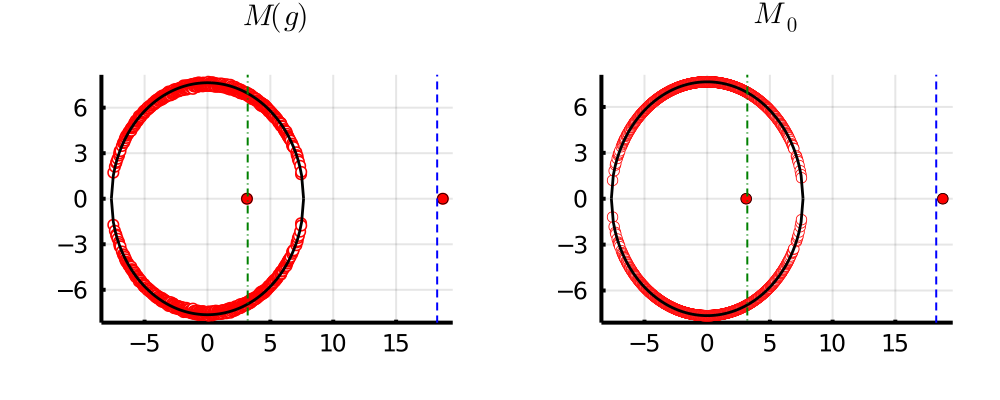

In [3]:
@time begin

n = 500 # number of nodes
c = 2*log(n)^2 # average degree
μ = 1 # mean of the gaussian
ν = 3. # standard deviation of the gaussian
β = 1 # temperature
    
A, edge_list = adjacency_matrix_ER(c,n) # generate the adjacency matrix of the Erdos-Renyi graph
w_edge_list = tanh.(β*rand(Normal(μ,ν), length(edge_list[:,1]))) # assign the gaussian weights independently at random

""" Here we build the matrix M(g) for one of the eigenvectors of the matrix B and then we diagonalize it """
    
B = B_matrix(edge_list, w_edge_list) # create the non-backtracking matrix
λ, X = eigsolve(B, 12, :LR) # compute some of the eigenvalues of B

F = F_matrix(edge_list, w_edge_list, λ[end], n) # use one of eigenvalues of B to build the matrix F
W = sparse(edge_list[:,1],edge_list[:,2], w_edge_list, n,n) # create sparse adjacency matrix
W = W+W'
Id = spdiagm(0 => ones(n)) # identity matrix
W2 = sparse(edge_list[:,1],edge_list[:,2], w_edge_list.^2, n,n) # create sparse adjacency matrix
W2 = W2+W2'    
Dw = spdiagm(0 => W2*ones(n))
Z = spdiagm(0 => zeros(n)) 

M = [W -Id; Dw-Id Z] # matrix M(g)
λ_M = eigvals(Array(M)) # compute the eigenvalues

""" Here we build be matrix M_0 and then we diagonalize it """
    

    
M0 = [W -Id; c*mean(w_edge_list.^2)*Id Z] # matrix M_0
λ_M0 = eigvals(Array(M0)) # compute the eigenvalues


end

p1 = scatter(real(λ_M), imag(λ_M), color = "white", markerstrokecolor = :red, markersize = 1.5, markerstrokewidth = 2)

v = λ_M[imag(λ_M) .== 0]
p1 = scatter!(real(v)[real(v) .> 1], imag(v)[real(v) .> 1], color = :red, markersize = 1.5, title = L"M(g)", titlefontsize = 5)
R = sqrt(c*mean(w_edge_list.^2))
x = LinRange(-R,R,100)
p1 = plot!(x, sqrt.(R^2 .- x.^2), color = "black", width = .7)
p1 = plot!(x, -sqrt.(R^2 .- x.^2), color = "black", width = .7)
p1 = vline!([c*mean(w_edge_list),mean(w_edge_list.^2)/mean(w_edge_list)], color = ["blue", "green"], style = [:dash, :dashdot], legend = false)

p2 = scatter(real(λ_M0), imag(λ_M0), color = "white", markerstrokecolor = :red, markersize = 1.5, markerstrokewidth = 1, titlefontsize = 5)

v0 = λ_M0[imag(λ_M0) .== 0]
p2 = scatter!(real(v0)[real(v0) .> 1.1], imag(v0)[real(v0) .> 1], color = "red", markersize = 1.5, title = L"M_0")
p2 = plot!(x, sqrt.(R^2 .- x.^2), color = "black", width = .7)
p2 = plot!(x, -sqrt.(R^2 .- x.^2), color = "black", width = .7)
p2 = vline!([c*mean(w_edge_list),mean(w_edge_list.^2)/mean(w_edge_list)], color = ["blue", "green"], style = [:dash, :dashdot], legend = false)

fn = plot(p1, p2, layout = Plots.grid(1, 2), size = (250, 100))


## Figure 4

This codes can be used to reproduce on pair of the spectra of the matrices $B$ and $H_{\beta, J}$ shown in Figure 4, for a given temperature.

More specifically, one of the four values of $\beta$ has to be selected, then the spectra of the two matrices are computed and shown. For visualization purposes, only the $100$ smallest eigenvalues of $H_{\beta, J}$ are shown. The same comments we made for the previous plots are still valid: small values of $n$ and $c$ allow one to have a small computational time, but the theoretical prediction may differ a little.

The following code runs in approximately $50$ seconds.

 65.813116 seconds (304.18 k allocations: 279.001 MiB, 0.04% gc time)


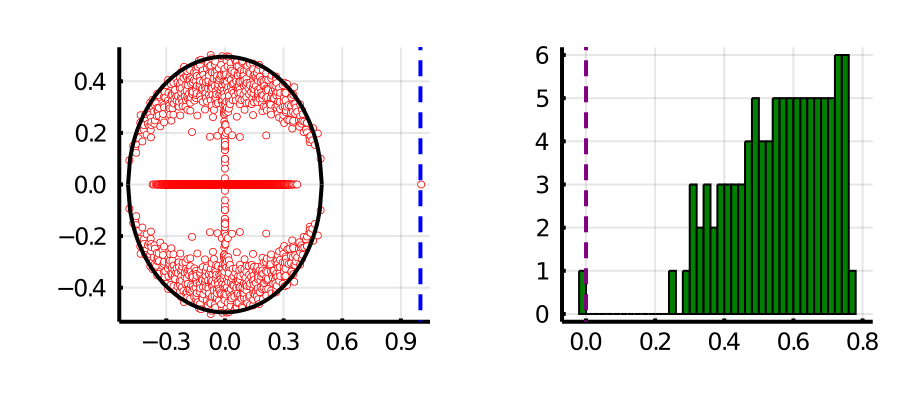

In [4]:
@time begin

n = 500 # number of nodes
c = 8. # average degree
μ = 1. # mean of the gaussian
ν = 1. # standard deviation of the gaussian
ϵ = 2*10^(-5) # precision of the estimates of the transition temperatures
    

    
A, edge_list = adjacency_matrix_ER(c,n) # generate the adjacency matrix of the Erdos-Renyi graph
J_edge_list = rand(Normal(μ,ν), length(edge_list[:,1])) # assign the gaussian weights independently at random

β_N = μ/ν^2 # Nishimori temperature
β_F =  β_F =  find_β_F(J_edge_list, c, 1., ϵ) # paramagnetic-ferromagentic phase transition temperature
β_SG =  find_β_SG(J_edge_list, c, 1., ϵ) # paramagnetic-spin glass phase transition temperature
β_para = β_F/2 # any β < β_F would work


β = β_F # select here the temperature
    
w_edge_list = tanh.(β*J_edge_list) 
    
B = B_matrix(edge_list, w_edge_list) # create the non-backtracking matrix    
λB = eigvals(Array(B)) # compute the eigenvalues of B
    
H = H_matrix(edge_list, w_edge_list, 1., n) # build the Bethe-Hessian matrix
λH = eigvals(Array(H)) # compute the eigenvalues of H

    
end
;

p1 = scatter(real(λB), imag(λB),
    color = "white", markerstrokecolor = :red, markersize = 1., markerstrokewidth = 1)
p1 = vline!([1], color = "blue", width = 1., style = :dash)
R = sqrt(c*mean(w_edge_list.^2))
x = LinRange(-R,R,100)
p1 = plot!(x, sqrt.(R^2 .- x.^2), color = "black", width = 1.)
p1 = plot!(x, -sqrt.(R^2 .- x.^2), color = "black", width = 1.)

p2 = histogram(λH[1:100], bins = 40, color = "green")
p2 = vline!([0], color = "purple", width = 1., style = :dash)

fn = plot(p1, p2 , size = (230, 100), legend = false)


## Figure 5

This code reproduces the left plot of figure 5, which provides the estimate of $\beta_{\rm N}$ for different values of $\beta_{\rm N}/\beta_{\rm SG}$. The code runs in approximately $20$ seconds. 

15 - 15
 18.651605 seconds (2.18 M allocations: 17.396 GiB, 4.60% gc time)


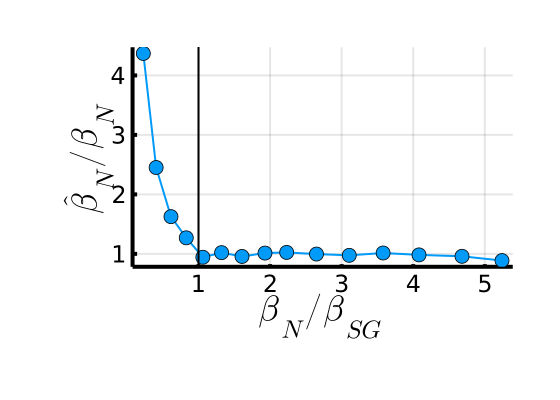

In [5]:
@time begin

n = 5000 # number of nodes
c = 5. # average degree
    
n_steps = 15 # number of different values of β_N considered
μ_v = LinRange(0.5,6.,n_steps) # mean of the gaussian
ν = 4. # standard deviation of the gaussian

β_N_v = zeros(n_steps)
β_SG_v = zeros(n_steps)
    
ϵ = 2*10^(-5) # precision error
    
A, edge_list = adjacency_matrix_ER(c,n) # generate the adjacency matrix of the Erdos-Renyi graph

for i=1:n_steps
        
    μ = μ_v[i] # update the mean
    J_edge_list = rand(Normal(μ,ν), length(edge_list[:,1])) # assign the gaussian weights independently at random
    β_SG =  find_β_SG(J_edge_list, c, 1., ϵ)
    β_SG_v[i] = β_SG
    β_N_v[i] = find_β_N(edge_list, J_edge_list, n, c, β_SG, verbose = 2)
    
    IJulia.clear_output(true)
    print(i, " - ", n_steps)
    print("\n")
        
end

    
end

plot((μ_v ./ ν^2) ./ β_SG_v, β_N_v ./ (μ_v ./ ν^2), marker = :dot, xlabel = L"\beta_{\rm N}/\beta_{\rm SG}", 
ylabel = L"\hat{\beta}_{\rm N}/\beta_{\rm N}", labelfontsize = 6)
vline!([1], legend = false, color = :black)